## Introduction
In this notebook we'll try to solve quite a challenging task. Using Blog Authorship Corpus which consists of the collected posts of 19,320 bloggers we'll try using solely text of this posts predict the gender, age, zodiac sign and industry of post author. For this I propose to use SentenceTransformers embeddings generated by Siamese BERT-Networks and classifier which is a small Neural Network with two linear layers. Starting with gender prediction model, which I consider the easiest one due to it's binary nature and nice almost ideal balance of classes, I'll proceed to more complex models trying to solve multiclass prediction problems for balanced and non-balanced classes. To speed up computation I'll use GPU, but if GPU is not available on your machine it will automatically compute everything on CPU.

## Content

1. [EDA](#EDA)
2. [Gender model](#Gender-model)
3. [Sign mdoel](#Sign-model)
4. [Age model](#Age-model)
5. [Topic model](#Topic-model)
6. [Summary and alternative approaches](#Summary-and-alternative-approaches)

In [ ]:
from model import Model
import pandas as pd
import numpy as np
import torch
pd.options.mode.chained_assignment = None
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pytorch_lightning import loggers as pl_loggers
from sentence_transformers import SentenceTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Define device (GPU if available, othervise CPU) and logger for Pytorch Lightning

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
comet_logger = pl_loggers.CometLogger(save_dir='logs/')

CometLogger will be initialized in offline mode


Read the dataset.

In [4]:
df = pd.read_csv('./data/blogtext.csv')
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


## EDA

There are few important things to be noticed during Exploratory Data Analysis in this case. First of all gender and sign are well balanced (classes almost equally distributed). Conversely, age and topic are not-balanced. Text length rarely exceeds threshold of 512 words, which is a cut-off value for BERT. There are records with empty posts. Numerous records have no topic specified.

In [5]:
df.shape

(681284, 7)

In [6]:
df.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

In [7]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [8]:
[(x, len(df[x].unique())) for x in df.columns]

[('id', 19320),
 ('gender', 2),
 ('age', 26),
 ('topic', 40),
 ('sign', 12),
 ('date', 2616),
 ('text', 611652)]

In [9]:
df['text_len'] = df.text.apply(lambda x: len(x.split()))

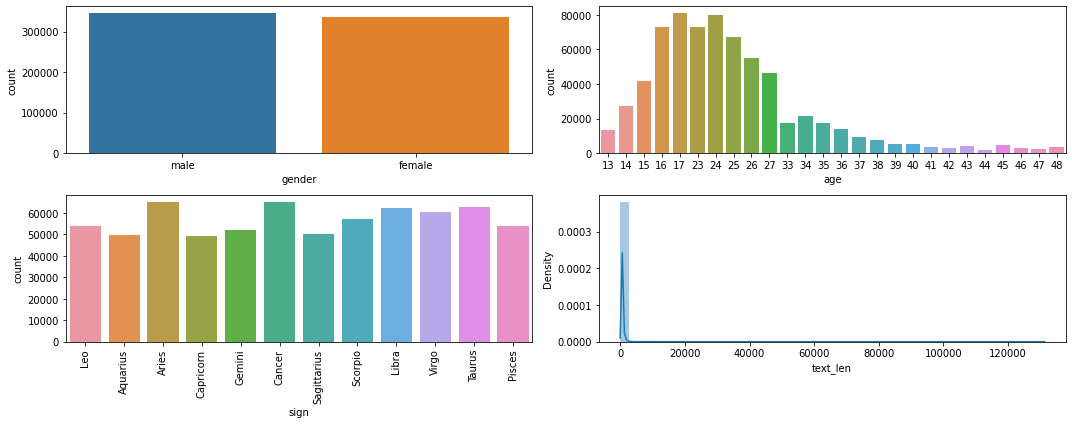

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (15, 6))
sns.countplot(x = df.gender, ax = ax[0][0])
sns.countplot(x = df.age, ax = ax[0][1])
sns.countplot(x = df.sign, ax = ax[1][0])
sns.distplot(a = df.text_len, ax = ax[1][1])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation = 90)
plt.tight_layout();

In [11]:
df.text_len.describe([.85, .9, .95, .99])

count    681284.000000
mean        200.786742
std         415.160622
min           0.000000
50%         112.000000
85%         370.000000
90%         470.000000
95%         663.000000
99%        1257.000000
max      131169.000000
Name: text_len, dtype: float64

In [12]:
df[df.text_len == 0].shape

(3119, 8)

In [13]:
df.topic.value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

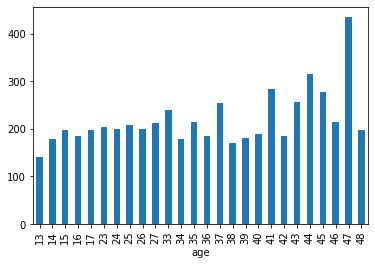

In [14]:
df.groupby('age').text_len.mean().plot(kind = 'bar');

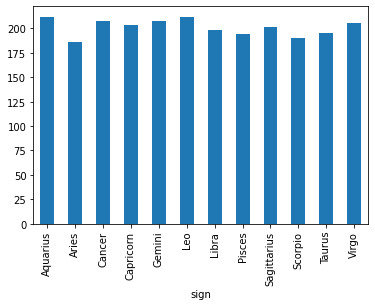

In [15]:
df.groupby('sign').text_len.mean().plot(kind = 'bar');

Let's filter out empty posts. For good practices I create a copy of existent dataset.

In [16]:
data = df[df.text_len > 0].copy()

In [17]:
data.shape

(678165, 8)

Fast preprocessing by lowercasing texts and removing redundant spaces.

In [18]:
def preprocess(text):
    text = text.lower().split()
    return " ".join(text)

In [19]:
%%time
data['prepr_text'] = data.text.apply(lambda x: preprocess(x))

CPU times: user 6.98 s, sys: 444 ms, total: 7.43 s
Wall time: 7.44 s


Let's encode sentences with SentenceTransformer. It will take a while. On my machine it took slightly above 2 hours.

In [20]:
st = SentenceTransformer('roberta-base-nli-stsb-mean-tokens').eval()

In [21]:
%%time
data['vectors'] = data.prepr_text.apply(lambda x: st.encode(x))
data.head()

KeyboardInterrupt: 

To make sure it's still no missings in the dataset.

In [23]:
data.isnull().sum()

id            0
gender        0
age           0
topic         0
sign          0
date          0
text          0
text_len      0
prepr_text    0
dtype: int64

Saving to pickle to not repeat sentences encoding.

In [18]:
data.to_pickle('./data/blogtext_vec.pkl')

In [137]:
df2 = pd.read_pickle('./data/blogtext_vec.pkl')
df2.head()

,id,gender,age,topic,sign,date,text,text_len,prepr_text,vectors
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",28,"info has been found (+/- 100 pages, and 4.5 mb...","[-0.022713589, -0.03159448, -0.1542669, -0.791..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,20,these are the team members: drewes van der l...,"[0.2918729, -0.55179924, 0.3165975, 1.6449755,..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,4326,in het kader van kernfusie op aarde: maak je ...,"[-0.19521914, -0.8037003, -0.5050227, -0.47326..."
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,2,testing!!! testing!!!,"[0.00037696637, -0.9026388, 0.32372972, 0.5517..."
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,65,thanks to yahoo!'s toolbar i can now 'capture'...,"[0.8108719, -0.2522956, -0.44623092, -0.710690..."


## Gender model

To convert gender labels to format acceptable by Neural Net we should map it to labels 0 and 1 for `female` and `male` respectively. We create dictionary to map gender values to labels and inverse dictionary to be able to identify which value predicted by the model.

In [138]:
gender_class2idx = {k: v for v, k in enumerate(sorted(df2['gender'].unique()))}
gender_idx2class = {v: k for k, v in gender_class2idx.items()}

In [139]:
gender_class2idx

{'female': 0, 'male': 1}

In [140]:
df2['gender'] = df2['gender'].map(gender_class2idx)

In [141]:
df2.gender.value_counts(normalize = True)

1    0.506509
0    0.493491
Name: gender, dtype: float64

Then we perform split on train, validation and test samples. I do this with two steps, firstly separating test sample, then spliting train and validation.

In [142]:
X = df2['vectors'].values
y = df2['gender'].values

In [143]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

As can be seen stratified split resulted in almost identical share of classes throughout all three samples.

In [9]:
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_val, return_counts=True)[1]/len(y_val))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))

[0.49349083 0.50650917]
[0.49348734 0.50651266]
[0.49349347 0.50650653]


In [10]:
print(X_train.size, X_val.size, X_test.size)

379772 162760 135633


The first run is simple sanity check. We just want to make sure, that there is no serious bug in the code of model implementation.

In [14]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger
}

In [15]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [16]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it, loss=0.708, v_num=f71c]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Epoch 0: avg_val_loss reached 0.73017 (best 0.73017), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, loss=0.708, v_num=f71c]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics:
COMET INFO:     avg_train_loss : 0.7083345055580139
COMET INFO:     avg_val_loss   : 0.7301679849624634
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     batch_size   : 32
COMET INFO:     device       : cuda
COMET INFO:     fast_dev_run : True
COMET INFO:     logger       : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f316c4eec90>
COMET INFO:     num_workers  : 12
COMET INFO:     pin_memory   : True
COMET INFO:     shuffle      : 1
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (2 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     gi

COMET INFO: Saving offline stats to disk before program termination (may take several seconds)
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/a80d5ff0764c4788a291eda0a9ccf71c.zip


CPU times: user 1.6 s, sys: 2.86 s, total: 4.46 s
Wall time: 6.28 s


Sanity check went well. Then to make sure NN is learning I try to overfit on small subsaple. And as can be seen below, model does it successfuly.

In [17]:
hparams = {
    'overfit_batches': 1e-3,
    'num_warmup_steps': 0,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'max_epochs': 40,
    'lr': 1e-3,
    'logger': comet_logger,
    'shuffle': False # it's important not to shuffle training samples
}

In [18]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [19]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  50%|█████     | 11/22 [00:01<00:01,  8.83it/s, loss=0.710, v_num=d466]
Validating: 0it [00:00, ?it/s]
Epoch 0:  59%|█████▉    | 13/22 [00:02<00:01,  5.19it/s, loss=0.710, v_num=d466]

Epoch 0: avg_val_loss reached 0.61816 (best 0.61816), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 1:  55%|█████▍    | 12/22 [00:01<00:01,  8.23it/s, loss=0.645, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Epoch 1: avg_val_loss reached 0.54207 (best 0.54207), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 2:  55%|█████▍    | 12/22 [00:01<00:01,  8.27it/s, loss=0.555, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Epoch 2: avg_val_loss reached 0.45747 (best 0.45747), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 3:  55%|█████▍    | 12/22 [00:01<00:00, 10.69it/s, loss=0.470, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.36s/it]

Epoch 3: avg_val_loss reached 0.36837 (best 0.36837), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 4:  55%|█████▍    | 12/22 [00:01<00:01,  9.02it/s, loss=0.381, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.38s/it]

Epoch 4: avg_val_loss reached 0.27995 (best 0.27995), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 5:  55%|█████▍    | 12/22 [00:01<00:00, 10.16it/s, loss=0.292, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

Epoch 5: avg_val_loss reached 0.20306 (best 0.20306), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 6:  55%|█████▍    | 12/22 [00:01<00:01,  9.04it/s, loss=0.214, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Epoch 6: avg_val_loss reached 0.14545 (best 0.14545), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 7:  55%|█████▍    | 12/22 [00:01<00:01,  8.83it/s, loss=0.152, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Epoch 7: avg_val_loss reached 0.10935 (best 0.10935), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 8:  55%|█████▍    | 12/22 [00:01<00:01,  8.22it/s, loss=0.109, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.44s/it]

Epoch 8: avg_val_loss reached 0.08004 (best 0.08004), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 9:  55%|█████▍    | 12/22 [00:01<00:00, 10.58it/s, loss=0.084, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.20s/it]

Epoch 9: avg_val_loss reached 0.05743 (best 0.05743), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 10:  55%|█████▍    | 12/22 [00:01<00:01,  9.82it/s, loss=0.068, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Epoch 10: avg_val_loss was not in top 1


Epoch 11:  55%|█████▍    | 12/22 [00:01<00:01,  9.41it/s, loss=0.059, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.50s/it]

Epoch 11: avg_val_loss reached 0.03521 (best 0.03521), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 12:  55%|█████▍    | 12/22 [00:01<00:01,  9.86it/s, loss=0.046, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.27s/it]

Epoch 12: avg_val_loss reached 0.03313 (best 0.03313), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 13:  55%|█████▍    | 12/22 [00:01<00:01,  9.23it/s, loss=0.034, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

Epoch 13: avg_val_loss reached 0.02355 (best 0.02355), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 14:  55%|█████▍    | 12/22 [00:01<00:01,  9.46it/s, loss=0.024, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.21s/it]

Epoch 14: avg_val_loss reached 0.01915 (best 0.01915), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 15:  55%|█████▍    | 12/22 [00:01<00:01,  9.51it/s, loss=0.019, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.35s/it]

Epoch 15: avg_val_loss reached 0.01646 (best 0.01646), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 16:  55%|█████▍    | 12/22 [00:01<00:01,  9.69it/s, loss=0.017, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.40s/it]

Epoch 16: avg_val_loss reached 0.01469 (best 0.01469), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 17:  55%|█████▍    | 12/22 [00:01<00:01,  8.30it/s, loss=0.015, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.43s/it]

Epoch 17: avg_val_loss reached 0.01331 (best 0.01331), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 18:  55%|█████▍    | 12/22 [00:01<00:01,  9.32it/s, loss=0.013, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

Epoch 18: avg_val_loss reached 0.01221 (best 0.01221), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 19:  55%|█████▍    | 12/22 [00:01<00:01,  8.87it/s, loss=0.012, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.33s/it]

Epoch 19: avg_val_loss reached 0.01130 (best 0.01130), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 20:  55%|█████▍    | 12/22 [00:01<00:01,  9.91it/s, loss=0.011, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.27s/it]

Epoch 20: avg_val_loss reached 0.01056 (best 0.01056), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 21:  55%|█████▍    | 12/22 [00:01<00:01,  9.07it/s, loss=0.011, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.35s/it]

Epoch 21: avg_val_loss reached 0.00994 (best 0.00994), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 22:  55%|█████▍    | 12/22 [00:01<00:01,  9.62it/s, loss=0.010, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.25s/it]

Epoch 22: avg_val_loss reached 0.00942 (best 0.00942), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 23:  55%|█████▍    | 12/22 [00:01<00:01,  8.53it/s, loss=0.009, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.18s/it]

Epoch 23: avg_val_loss reached 0.00898 (best 0.00898), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 24:  55%|█████▍    | 12/22 [00:01<00:01,  9.38it/s, loss=0.009, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.22s/it]

Epoch 24: avg_val_loss reached 0.00860 (best 0.00860), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 25:  55%|█████▍    | 12/22 [00:01<00:01,  8.63it/s, loss=0.009, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.35s/it]

Epoch 25: avg_val_loss reached 0.00829 (best 0.00829), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 26:  55%|█████▍    | 12/22 [00:01<00:01,  7.99it/s, loss=0.008, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.38s/it]

Epoch 26: avg_val_loss reached 0.00802 (best 0.00802), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 27:  55%|█████▍    | 12/22 [00:01<00:01,  9.00it/s, loss=0.008, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.21s/it]

Epoch 27: avg_val_loss reached 0.00779 (best 0.00779), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 28:  55%|█████▍    | 12/22 [00:01<00:01,  8.34it/s, loss=0.008, v_num=d466]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Epoch 28: avg_val_loss reached 0.00760 (best 0.00760), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 28: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s, loss=0.008, v_num=d466]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [29] : (0.00774011155590415, 0.709528923034668)
COMET INFO:     avg_val_loss [29]   : (0.007600727025419474, 0.6181642413139343)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f30825ed290>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 40
COMET INFO:     num_warmup_steps : 1
COMET INFO:     num_workers      : 12
COMET INFO:     overfit_batches  : 0.001
COMET INFO:     pin_memory       : True
COMET INFO:     shuffle          : 1
C

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/29a55aa469964b0f95ee2aba7efad466.zip


CPU times: user 4.6 s, sys: 1min 19s, total: 1min 23s
Wall time: 1min 32s


Finally, running the model itself. I specified 2000 warmup steps and learning rate 0.001. Model automatically will stop if validation loss averaged on batches will not reduce for three consecutive epochs at least by 0.001. Additionally it will save the best model in checkpoint folder for us to be able to load it and try on test sample. There are some additional features which are provided by Pytorch Lightning, like learning rate scheduler and different logging possibilities.

In [144]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000
}

In [21]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [22]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

Let's check the mertics before training. By now model is not better than a random one.

In [23]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1011.23it/s]

              precision    recall  f1-score   support

           0      0.493     0.995     0.660     66934
           1      0.464     0.004     0.008     68699

    accuracy                          0.493    135633
   macro avg      0.479     0.500     0.334    135633
weighted avg      0.478     0.493     0.329    135633



In [24]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.55it/s, loss=0.636, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████▉| 16890/16955 [01:02<00:00, 271.38it/s, loss=0.636, v_num=84fe]

Epoch 0: avg_val_loss reached 0.63533 (best 0.63533), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.28it/s, loss=0.638, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5068/5087 [00:07<00:00, 836.76it/s]

Epoch 1: avg_val_loss reached 0.62642 (best 0.62642), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:54<00:23, 219.14it/s, loss=0.639, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5082/5087 [00:07<00:00, 799.93it/s]

Epoch 2: avg_val_loss reached 0.62397 (best 0.62397), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:53<00:23, 220.21it/s, loss=0.629, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5068/5087 [00:07<00:00, 819.88it/s]

Epoch 3: avg_val_loss reached 0.62299 (best 0.62299), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:53<00:23, 220.66it/s, loss=0.619, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 16910/16955 [01:01<00:00, 275.41it/s, loss=0.619, v_num=84fe]

Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:53<00:23, 219.79it/s, loss=0.632, v_num=84fe]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5075/5087 [00:07<00:00, 793.46it/s]

Epoch 5: avg_val_loss was not in top 1


Epoch 5: 100%|██████████| 16955/16955 [01:02<00:00, 270.26it/s, loss=0.632, v_num=84fe]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [6] : (0.6114534139633179, 0.6377289891242981)
COMET INFO:     avg_val_loss [6]   : (0.62298583984375, 0.6353290677070618)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f3082566190>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 30
COMET INFO:     num_warmup_steps : 2000
COMET INFO:     num_workers      : 12
COMET INFO:     pin_memory       : True
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (2 KB)
COMET I

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/086406ea3ad14099be20c2c57cde84fe.zip


CPU times: user 6min 13s, sys: 1min 7s, total: 7min 20s
Wall time: 6min 19s


Let's load the best model from checkpoint and see quite a good performance. The model is able to predict blogger's gender quite successfuly. All metrics are above 60%, F1 score is apx. 65%. 

In [145]:
gender_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams,\
                                   checkpoint_path="./checkpoints/model-outputs-v2.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [146]:
gender_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [27]:
gender_model = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1000.76it/s]

              precision    recall  f1-score   support

           0      0.638     0.655     0.646     66934
           1      0.655     0.638     0.646     68699

    accuracy                          0.646    135633
   macro avg      0.646     0.646     0.646    135633
weighted avg      0.646     0.646     0.646    135633



## Sign model

Let's proceed with more challenging model. Multiclass classification task - sign prediciton. As previously, classes are well balanced. Let's create label mapping.

In [147]:
sign_class2idx = {k: v for v, k in enumerate(sorted(df2['sign'].unique()))}
sign_idx2class = {v: k for k, v in sign_class2idx.items()}

In [148]:
sign_class2idx

{'Aquarius': 0,
 'Aries': 1,
 'Cancer': 2,
 'Capricorn': 3,
 'Gemini': 4,
 'Leo': 5,
 'Libra': 6,
 'Pisces': 7,
 'Sagittarius': 8,
 'Scorpio': 9,
 'Taurus': 10,
 'Virgo': 11}

In [149]:
df2['sign'] = df2['sign'].map(sign_class2idx)

Exactly the same stratified samples splitting.

In [150]:
X = df2['vectors'].values
y = df2['sign'].values

In [151]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

Sanity check and overfitting on small subsample.

In [33]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger
}

In [34]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [35]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=2.510, v_num=acc5]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Epoch 0: avg_val_loss reached 2.48216 (best 2.48216), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=2.510, v_num=acc5]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics:
COMET INFO:     avg_train_loss : 2.5097577571868896
COMET INFO:     avg_val_loss   : 2.4821643829345703
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     batch_size   : 32
COMET INFO:     device       : cuda
COMET INFO:     fast_dev_run : True
COMET INFO:     logger       : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f308252c4d0>
COMET INFO:     num_workers  : 12
COMET INFO:     pin_memory   : True
COMET INFO:     shuffle      : 1
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (4 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     gi

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/9dc47277e5b8486681301f03fbc2acc5.zip


CPU times: user 128 ms, sys: 3.05 s, total: 3.18 s
Wall time: 4.37 s


In [36]:
hparams = {
    'overfit_batches': 1e-3,
    'num_warmup_steps': 0,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'max_epochs': 40,
    'lr': 1e-3,
    'logger': comet_logger,
    'shuffle': False # it's important not to shuffle training samples
}

In [37]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [38]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  50%|█████     | 11/22 [00:01<00:01,  7.06it/s, loss=2.500, v_num=1925]
Validating: 0it [00:00, ?it/s]
Epoch 0:  59%|█████▉    | 13/22 [00:03<00:02,  4.30it/s, loss=2.500, v_num=1925]

Epoch 0: avg_val_loss reached 2.26759 (best 2.26759), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 1:  55%|█████▍    | 12/22 [00:01<00:01,  9.35it/s, loss=2.339, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it]

Epoch 1: avg_val_loss reached 2.04776 (best 2.04776), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 2:  55%|█████▍    | 12/22 [00:01<00:01,  8.43it/s, loss=2.098, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.44s/it]

Epoch 2: avg_val_loss reached 1.84188 (best 1.84188), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 3:  55%|█████▍    | 12/22 [00:01<00:01,  7.26it/s, loss=1.893, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.41s/it]

Epoch 3: avg_val_loss reached 1.64989 (best 1.64989), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 4:  55%|█████▍    | 12/22 [00:01<00:01,  8.69it/s, loss=1.699, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.50s/it]

Epoch 4: avg_val_loss reached 1.46831 (best 1.46831), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 5:  55%|█████▍    | 12/22 [00:01<00:01,  8.22it/s, loss=1.517, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.48s/it]

Epoch 5: avg_val_loss reached 1.29799 (best 1.29799), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 6:  55%|█████▍    | 12/22 [00:01<00:01,  8.19it/s, loss=1.347, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it]

Epoch 6: avg_val_loss reached 1.13889 (best 1.13889), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 7:  55%|█████▍    | 12/22 [00:01<00:01,  9.93it/s, loss=1.187, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.52s/it]

Epoch 7: avg_val_loss reached 0.99200 (best 0.99200), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 8:  55%|█████▍    | 12/22 [00:01<00:01,  7.51it/s, loss=1.039, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.46s/it]

Epoch 8: avg_val_loss reached 0.85717 (best 0.85717), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 9:  55%|█████▍    | 12/22 [00:01<00:00, 10.33it/s, loss=0.903, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.40s/it]

Epoch 9: avg_val_loss reached 0.73485 (best 0.73485), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 10:  55%|█████▍    | 12/22 [00:01<00:01,  7.99it/s, loss=0.778, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.48s/it]

Epoch 10: avg_val_loss reached 0.62617 (best 0.62617), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 11:  55%|█████▍    | 12/22 [00:01<00:01,  8.08it/s, loss=0.665, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.55s/it]

Epoch 11: avg_val_loss reached 0.52989 (best 0.52989), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 12:  55%|█████▍    | 12/22 [00:01<00:01,  7.89it/s, loss=0.565, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Epoch 12: avg_val_loss reached 0.44643 (best 0.44643), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 13:  55%|█████▍    | 12/22 [00:01<00:01,  8.41it/s, loss=0.478, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.53s/it]

Epoch 13: avg_val_loss reached 0.37453 (best 0.37453), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 14:  55%|█████▍    | 12/22 [00:01<00:01,  7.34it/s, loss=0.401, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.42s/it]

Epoch 14: avg_val_loss reached 0.31476 (best 0.31476), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 15:  55%|█████▍    | 12/22 [00:01<00:01,  7.39it/s, loss=0.337, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.47s/it]

Epoch 15: avg_val_loss reached 0.26465 (best 0.26465), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 16:  55%|█████▍    | 12/22 [00:01<00:01,  7.42it/s, loss=0.283, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.52s/it]

Epoch 16: avg_val_loss reached 0.22390 (best 0.22390), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 17:  55%|█████▍    | 12/22 [00:01<00:01,  7.42it/s, loss=0.239, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.43s/it]

Epoch 17: avg_val_loss reached 0.19080 (best 0.19080), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 18:  55%|█████▍    | 12/22 [00:01<00:01,  7.69it/s, loss=0.203, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.46s/it]

Epoch 18: avg_val_loss reached 0.16450 (best 0.16450), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 19:  55%|█████▍    | 12/22 [00:01<00:01,  7.64it/s, loss=0.174, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.30s/it]

Epoch 19: avg_val_loss reached 0.14359 (best 0.14359), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 20:  55%|█████▍    | 12/22 [00:01<00:01,  7.22it/s, loss=0.151, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it]

Epoch 20: avg_val_loss reached 0.12700 (best 0.12700), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 21:  55%|█████▍    | 12/22 [00:01<00:01,  8.26it/s, loss=0.133, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.48s/it]

Epoch 21: avg_val_loss reached 0.11386 (best 0.11386), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 22:  55%|█████▍    | 12/22 [00:01<00:01,  9.42it/s, loss=0.118, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.39s/it]

Epoch 22: avg_val_loss reached 0.10328 (best 0.10328), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 23:  55%|█████▍    | 12/22 [00:01<00:01,  8.07it/s, loss=0.107, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.40s/it]

Epoch 23: avg_val_loss reached 0.09479 (best 0.09479), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 24:  55%|█████▍    | 12/22 [00:01<00:01,  7.38it/s, loss=0.098, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Epoch 24: avg_val_loss reached 0.08794 (best 0.08794), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 25:  55%|█████▍    | 12/22 [00:01<00:01,  8.15it/s, loss=0.090, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.43s/it]

Epoch 25: avg_val_loss reached 0.08241 (best 0.08241), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 26:  55%|█████▍    | 12/22 [00:01<00:01,  7.66it/s, loss=0.084, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.47s/it]

Epoch 26: avg_val_loss reached 0.07798 (best 0.07798), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 27:  55%|█████▍    | 12/22 [00:01<00:01,  8.16it/s, loss=0.080, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.50s/it]

Epoch 27: avg_val_loss reached 0.07442 (best 0.07442), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 28:  55%|█████▍    | 12/22 [00:01<00:01,  8.17it/s, loss=0.076, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.27s/it]

Epoch 28: avg_val_loss reached 0.07158 (best 0.07158), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 29:  55%|█████▍    | 12/22 [00:01<00:01,  7.62it/s, loss=0.073, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.39s/it]

Epoch 29: avg_val_loss reached 0.06927 (best 0.06927), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 30:  55%|█████▍    | 12/22 [00:01<00:01,  8.07it/s, loss=0.070, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.36s/it]

Epoch 30: avg_val_loss reached 0.06743 (best 0.06743), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 31:  55%|█████▍    | 12/22 [00:01<00:01,  8.56it/s, loss=0.068, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.50s/it]

Epoch 31: avg_val_loss reached 0.06598 (best 0.06598), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 32:  55%|█████▍    | 12/22 [00:01<00:01,  8.42it/s, loss=0.067, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.41s/it]

Epoch 32: avg_val_loss reached 0.06484 (best 0.06484), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 33:  55%|█████▍    | 12/22 [00:01<00:01,  7.57it/s, loss=0.066, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.40s/it]

Epoch 33: avg_val_loss reached 0.06398 (best 0.06398), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 34:  55%|█████▍    | 12/22 [00:01<00:01,  8.76it/s, loss=0.065, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.37s/it]

Epoch 34: avg_val_loss reached 0.06335 (best 0.06335), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 35:  55%|█████▍    | 12/22 [00:01<00:01,  8.29it/s, loss=0.064, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.39s/it]

Epoch 35: avg_val_loss reached 0.06291 (best 0.06291), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 36:  55%|█████▍    | 12/22 [00:01<00:01,  8.39it/s, loss=0.063, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it]

Epoch 36: avg_val_loss reached 0.06263 (best 0.06263), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 37:  55%|█████▍    | 12/22 [00:01<00:01,  8.88it/s, loss=0.063, v_num=1925]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.47s/it]

Epoch 37: avg_val_loss reached 0.06247 (best 0.06247), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 37: 100%|██████████| 22/22 [00:03<00:00,  6.57it/s, loss=0.063, v_num=1925]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [38] : (0.06259336322546005, 2.5002431869506836)
COMET INFO:     avg_val_loss [38]   : (0.062467437237501144, 2.2675886154174805)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f306e6f0510>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 40
COMET INFO:     num_warmup_steps : 1
COMET INFO:     num_workers      : 12
COMET INFO:     overfit_batches  : 0.001
COMET INFO:     pin_memory       : True
COMET INFO:     shuffle          : 1


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/36638a1ddfd246db882aea0fd58f1925.zip


CPU times: user 3.7 s, sys: 1min 57s, total: 2min 1s
Wall time: 2min 13s


Let's add a dropout this time.

In [152]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2
}

In [40]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [41]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=12, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

Trditionally checking metrics before learning.

In [42]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1035.39it/s]

              precision    recall  f1-score   support

           0      0.073     0.019     0.030      9893
           1      0.094     0.109     0.101     12961
           2      0.095     0.078     0.086     12949
           3      0.060     0.006     0.011      9801
           4      0.077     0.334     0.125     10344
           5      0.073     0.016     0.026     10708
           6      0.090     0.001     0.001     12412
           7      0.080     0.306     0.126     10757
           8      0.065     0.001     0.001      9963
           9      0.115     0.001     0.001     11370
          10      0.097     0.002     0.005     12453
          11      0.091     0.131     0.107     12022

    accuracy                          0.083    135633
   macro avg      0.084     0.083     0.052    135633
weighted avg      0.085     0.083     0.053    135633



In [43]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  70%|██████▉   | 11868/16955 [00:53<00:22, 223.48it/s, loss=2.465, v_num=e839]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5069/5087 [00:07<00:00, 838.26it/s]

Epoch 0: avg_val_loss reached 2.46381 (best 2.46381), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:53<00:22, 223.05it/s, loss=2.457, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████▉| 16954/16955 [01:00<00:00, 278.39it/s, loss=2.457, v_num=e839]

Epoch 1: avg_val_loss reached 2.45950 (best 2.45950), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:52<00:22, 225.61it/s, loss=2.454, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 16954/16955 [01:00<00:00, 281.94it/s, loss=2.454, v_num=e839]

Epoch 2: avg_val_loss reached 2.45532 (best 2.45532), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:52<00:22, 224.48it/s, loss=2.452, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 16954/16955 [01:00<00:00, 279.30it/s, loss=2.452, v_num=e839]

Epoch 3: avg_val_loss reached 2.45404 (best 2.45404), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:52<00:22, 225.20it/s, loss=2.460, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 16954/16955 [01:00<00:00, 282.05it/s, loss=2.460, v_num=e839]

Epoch 4: avg_val_loss reached 2.45359 (best 2.45359), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:52<00:22, 224.55it/s, loss=2.451, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 16954/16955 [01:00<00:00, 279.86it/s, loss=2.451, v_num=e839]

Epoch 5: avg_val_loss reached 2.45291 (best 2.45291), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 6:  70%|██████▉   | 11868/16955 [00:53<00:22, 223.10it/s, loss=2.451, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 16954/16955 [01:00<00:00, 279.44it/s, loss=2.451, v_num=e839]

Epoch 6: avg_val_loss was not in top 1


Epoch 7:  70%|██████▉   | 11868/16955 [00:53<00:22, 222.93it/s, loss=2.438, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████▉| 16954/16955 [01:00<00:00, 278.11it/s, loss=2.438, v_num=e839]

Epoch 7: avg_val_loss was not in top 1


Epoch 8:  70%|██████▉   | 11868/16955 [00:53<00:23, 220.27it/s, loss=2.445, v_num=e839]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█████████▉| 16954/16955 [01:01<00:00, 275.53it/s, loss=2.445, v_num=e839]

Epoch 8: avg_val_loss was not in top 1


Epoch 8: 100%|██████████| 16955/16955 [01:02<00:00, 271.29it/s, loss=2.445, v_num=e839]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [9] : (2.438805341720581, 2.472425937652588)
COMET INFO:     avg_val_loss [9]   : (2.4529061317443848, 2.4638121128082275)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     dropout          : 0.2
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7f30824ecad0>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 30
COMET INFO:     num_warmup_steps : 2000
COMET INFO:     num_workers      : 12
COMET INFO:     pin_memory       : True
COMET INFO:   Uploads:
COMET INFO:     code

COMET INFO: To upload this offline experiment, run:
    comet upload logs/0e9416ac8e894f2e920277f7793ce839.zip


CPU times: user 9min 15s, sys: 1min 35s, total: 10min 50s
Wall time: 9min 16s


In [153]:
sign_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams,\
                                   checkpoint_path="./checkpoints/model-outputs-v5.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [154]:
sign_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=12, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [46]:
pred = sign_model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1057.28it/s]


              precision    recall  f1-score   support

           0      0.178     0.060     0.090      9893
           1      0.197     0.098     0.131     12961
           2      0.258     0.077     0.118     12949
           3      0.391     0.001     0.002      9801
           4      0.416     0.014     0.027     10344
           5      0.344     0.024     0.045     10708
           6      0.094     0.817     0.168     12412
           7      0.270     0.032     0.058     10757
           8      0.119     0.093     0.104      9963
           9      0.237     0.019     0.036     11370
          10      0.140     0.015     0.028     12453
          11      0.168     0.022     0.040     12022

    accuracy                          0.113    135633
   macro avg      0.234     0.106     0.071    135633
weighted avg      0.230     0.113     0.073    135633



Metrics are higher now, but still, the model is weak. To be fair, the task sounds a bit impossible, considering that it's hard to find any patterns which are specific for zodiac signs, especially in texts. 

## Age model

Now it's turn for age prediction model. Classes are not balanced, we'll try to deal with it. Repeating again prepararion routine.

In [155]:
age_class2idx = {k: v for v, k in enumerate(sorted(df2['age'].unique()))}
age_idx2class = {v: k for k, v in age_class2idx.items()}

In [156]:
age_class2idx

{13: 0,
 14: 1,
 15: 2,
 16: 3,
 17: 4,
 23: 5,
 24: 6,
 25: 7,
 26: 8,
 27: 9,
 33: 10,
 34: 11,
 35: 12,
 36: 13,
 37: 14,
 38: 15,
 39: 16,
 40: 17,
 41: 18,
 42: 19,
 43: 20,
 44: 21,
 45: 22,
 46: 23,
 47: 24,
 48: 25}

In [157]:
df2['age'] = df2['age'].map(age_class2idx)

In [201]:
X = df2['vectors'].values
y = df2['age'].values

In [202]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

As classes are highly disbalanced we want artificially increase number of times NN sees rare classes. So I provide weights for training instances to activate `WeightedRandomSampler`.

In [160]:
def get_class_distribution(y_label):
    return dict(df2[y_label].value_counts().sort_index())

In [203]:
target_list = torch.tensor(y_train)

In [204]:
class_count = [i for i in get_class_distribution('age').values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

In [205]:
class_weights_all = class_weights[target_list]

In [206]:
class_weights_all

tensor([4.6968e-05, 2.3787e-04, 7.6728e-05,  ..., 1.3801e-05, 1.2532e-05,
        2.1786e-05])

In [58]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger,
    'weights': class_weights_all
}

In [59]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [60]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 101 K 


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it, loss=3.299, v_num=a4ff]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Epoch 0: avg_val_loss reached 3.23989 (best 3.23989), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it, loss=3.299, v_num=a4ff]

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/04e9cc18d1d64f59b707d639a7c2a4ff.zip



CPU times: user 4.09 s, sys: 2.94 s, total: 7.03 s
Wall time: 7.35 s


In [199]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2,
    'weights': class_weights_all
}

In [67]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [68]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=26, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [69]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1023.47it/s]
/home/payonear/Cases_recruit/netguru-case/netguru-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000      2607
           1      0.033     0.013     0.019      5456
           2      0.066     0.029     0.041      8314
           3      0.057     0.000     0.000     14492
           4      0.125     0.000     0.000     16107
           5      0.123     0.003     0.006     14493
           6      0.125     0.001     0.001     15959
           7      0.094     0.037     0.053     13348
           8      0.000     0.000     0.000     11014
           9      0.084     0.005     0.009      9180
          10      0.024     0.001     0.001      3498
          11      0.051     0.010     0.017      4258
          12      0.038     0.020     0.026      3481
          13      0.000     0.000     0.000      2835
          14      0.014     0.269     0.026      1853
          15      0.009     0.012     0.011      1484
          16      0.006     0.011     0.008      1092
          17      0.006    

In [70]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 101 K 


Epoch 0:  70%|██████▉   | 11868/16955 [00:54<00:23, 219.07it/s, loss=2.785, v_num=946a]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5055/5087 [00:07<00:00, 802.49it/s]

Epoch 0: avg_val_loss reached 2.96739 (best 2.96739), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v7.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:53<00:22, 221.55it/s, loss=2.521, v_num=946a]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5055/5087 [00:07<00:00, 831.17it/s]

Epoch 1: avg_val_loss reached 2.87084 (best 2.87084), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v8.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:54<00:23, 218.24it/s, loss=2.538, v_num=946a]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5062/5087 [00:07<00:00, 826.78it/s]

Epoch 2: avg_val_loss was not in top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.15it/s, loss=2.579, v_num=946a]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 16910/16955 [01:02<00:00, 272.02it/s, loss=2.579, v_num=946a]

Epoch 3: avg_val_loss reached 2.84829 (best 2.84829), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v7.ckpt as top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:54<00:23, 216.43it/s, loss=2.469, v_num=946a]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5052/5087 [00:07<00:00, 807.14it/s]

Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.58it/s, loss=2.429, v_num=946a]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5061/5087 [00:07<00:00, 831.14it/s]

Epoch 5: avg_val_loss was not in top 1


Epoch 6:  70%|██████▉   | 11868/16955 [00:54<00:23, 218.91it/s, loss=2.394, v_num=946a]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 16910/16955 [01:01<00:00, 273.55it/s, loss=2.394, v_num=946a]

Epoch 6: avg_val_loss was not in top 1


Epoch 6: 100%|██████████| 16955/16955 [01:02<00:00, 269.88it/s, loss=2.394, v_num=946a]


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/2708165c013247eb966a30532e4d946a.zip


CPU times: user 7min 24s, sys: 1min 15s, total: 8min 40s
Wall time: 7min 27s


In [207]:
age_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams, \
                                   checkpoint_path="./checkpoints/model-outputs-v7.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [208]:
age_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=26, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [73]:
pred = age_model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1021.31it/s]


              precision    recall  f1-score   support

           0      0.076     0.194     0.109      2607
           1      0.125     0.383     0.189      5456
           2      0.128     0.051     0.073      8314
           3      0.178     0.079     0.109     14492
           4      0.227     0.190     0.207     16107
           5      0.166     0.053     0.080     14493
           6      0.172     0.075     0.105     15959
           7      0.141     0.075     0.098     13348
           8      0.183     0.006     0.012     11014
           9      0.104     0.028     0.045      9180
          10      0.061     0.040     0.049      3498
          11      0.241     0.167     0.198      4258
          12      0.075     0.065     0.069      3481
          13      0.057     0.051     0.054      2835
          14      0.070     0.138     0.093      1853
          15      0.034     0.143     0.054      1484
          16      0.022     0.179     0.039      1092
          17      0.101    

Averaged weighted F-1 Score equals 10.3% which is considerably better than for random model, still not satisfactory. But again, predicting text author's age is extremely complex task. 

## Topic model

As we remember, numerous records have not specified the topic. We probably not interested in predicting unknown industry. So I remove records with no topic specified.

In [168]:
topic_df = df2[df2.topic != 'indUnk'].copy()

In [169]:
topic_df.shape

(428278, 10)

Again classes mapping and samples split.

In [170]:
topic_class2idx = {k: v for v, k in enumerate(sorted(topic_df['topic'].unique()))}
topic_idx2class = {v: k for k, v in topic_class2idx.items()}

In [171]:
topic_class2idx

{'Accounting': 0,
 'Advertising': 1,
 'Agriculture': 2,
 'Architecture': 3,
 'Arts': 4,
 'Automotive': 5,
 'Banking': 6,
 'Biotech': 7,
 'BusinessServices': 8,
 'Chemicals': 9,
 'Communications-Media': 10,
 'Construction': 11,
 'Consulting': 12,
 'Education': 13,
 'Engineering': 14,
 'Environment': 15,
 'Fashion': 16,
 'Government': 17,
 'HumanResources': 18,
 'Internet': 19,
 'InvestmentBanking': 20,
 'Law': 21,
 'LawEnforcement-Security': 22,
 'Manufacturing': 23,
 'Maritime': 24,
 'Marketing': 25,
 'Military': 26,
 'Museums-Libraries': 27,
 'Non-Profit': 28,
 'Publishing': 29,
 'RealEstate': 30,
 'Religion': 31,
 'Science': 32,
 'Sports-Recreation': 33,
 'Student': 34,
 'Technology': 35,
 'Telecommunications': 36,
 'Tourism': 37,
 'Transportation': 38}

In [172]:
topic_df['topic'] = topic_df['topic'].map(topic_class2idx)

In [173]:
X = topic_df['vectors'].values
y = topic_df['topic'].values

In [174]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

In [175]:
target_list = torch.tensor(y_train)
class_count = [i for i in get_class_distribution('topic').values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[target_list]

In [82]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger,
    'weights': class_weights_all
}

In [83]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [84]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 103 K 


Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.06s/it, loss=3.662, v_num=f3df]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

Epoch 0: avg_val_loss reached 3.65514 (best 3.65514), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v8.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it, loss=3.662, v_num=f3df]


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/21c5c34b8e1a449aa163461147b0f3df.zip


CPU times: user 2.57 s, sys: 3.3 s, total: 5.87 s
Wall time: 6.47 s


In [176]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2,
    'weights': class_weights_all
}

In [86]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [87]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=39, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [88]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 2677/2677 [00:02<00:00, 950.71it/s]

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       764
           1      0.012     0.005     0.008       931
           2      0.003     0.024     0.005       246
           3      0.003     0.040     0.006       325
           4      0.070     0.353     0.117      6460
           5      0.000     0.000     0.000       248
           6      0.000     0.000     0.000       807
           7      0.000     0.000     0.000       446
           8      0.005     0.003     0.004       895
           9      0.000     0.000     0.000       782
          10      0.066     0.010     0.018      4003
          11      0.000     0.000     0.000       218
          12      0.000     0.000     0.000      1169
          13      0.058     0.015     0.024      5917
          14      0.000     0.000     0.000      2304
          15      0.000     0.000     0.000       117
          16      0.012     0.005     0.007       967
          17      0.029    


/home/payonear/Cases_recruit/netguru-case/netguru-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 103 K 


Epoch 0:  70%|██████▉   | 7495/10708 [00:34<00:14, 216.55it/s, loss=3.265, v_num=f535]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████▉| 10705/10708 [00:39<00:00, 268.03it/s, loss=3.265, v_num=f535]

Epoch 0: avg_val_loss reached 3.43985 (best 3.43985), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v9.ckpt as top 1


Epoch 1:  70%|██████▉   | 7495/10708 [00:34<00:14, 214.71it/s, loss=3.047, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 3200/3213 [00:05<00:00, 855.71it/s]

Epoch 1: avg_val_loss reached 3.42638 (best 3.42638), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v10.ckpt as top 1


Epoch 2:  70%|██████▉   | 7495/10708 [00:35<00:15, 212.34it/s, loss=3.026, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 10647/10708 [00:40<00:00, 263.84it/s, loss=3.026, v_num=f535]

Epoch 2: avg_val_loss was not in top 1


Epoch 3:  70%|██████▉   | 7495/10708 [00:35<00:15, 214.08it/s, loss=2.819, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 3200/3213 [00:05<00:00, 838.34it/s]

Epoch 3: avg_val_loss reached 3.39029 (best 3.39029), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v9.ckpt as top 1


Epoch 4:  70%|██████▉   | 7495/10708 [00:35<00:15, 213.46it/s, loss=2.766, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 3175/3213 [00:05<00:00, 810.58it/s]

Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 7495/10708 [00:35<00:15, 213.64it/s, loss=2.812, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 3202/3213 [00:05<00:00, 814.84it/s]

Epoch 5: avg_val_loss was not in top 1


Epoch 6:  70%|██████▉   | 7495/10708 [00:35<00:15, 212.51it/s, loss=2.765, v_num=f535] 
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▊| 3167/3213 [00:05<00:00, 789.38it/s]

Epoch 6: avg_val_loss was not in top 1


Epoch 6: 100%|██████████| 10708/10708 [00:41<00:00, 258.14it/s, loss=2.765, v_num=f535]


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/5f40e3d743a7484ebcfac4921f45f535.zip


CPU times: user 4min 41s, sys: 56.4 s, total: 5min 37s
Wall time: 4min 52s


In [177]:
topic_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams, \
                                   checkpoint_path="./checkpoints/model-outputs-v9.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [178]:
topic_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=39, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [23]:
pred = topic_model.predict_eval(X_test, y_test)

100%|██████████| 2677/2677 [00:02<00:00, 1004.04it/s]

              precision    recall  f1-score   support

           0      0.067     0.141     0.091       764
           1      0.028     0.070     0.040       931
           2      0.007     0.118     0.014       246
           3      0.028     0.243     0.050       325
           4      0.126     0.005     0.010      6460
           5      0.009     0.177     0.018       248
           6      0.042     0.089     0.057       807
           7      0.022     0.177     0.039       446
           8      0.098     0.111     0.104       895
           9      0.046     0.072     0.056       782
          10      0.073     0.013     0.022      4003
          11      0.017     0.138     0.030       218
          12      0.034     0.022     0.027      1169
          13      0.249     0.010     0.020      5917
          14      0.091     0.020     0.033      2304
          15      0.009     0.077     0.016       117
          16      0.051     0.146     0.076       967
          17      0.029    

Model has learnt a bit. Not much better than random model.

## Summary and alternative approaches

So, in this notebook we built 4 models, predicting gender, zodiac sign, age and industry of post's author. For the first model we found out that text semantic allows us identify the gender of the author with accuray in 65% (F1-score - 65%). In case of age, zodiac sign and industry prediction tasks the models were not so successful. Why were we able to predict gender, but experienced hard time predicting all the other classes. So, imagine you have a task, the same as the model, you want to identify who wrote the post. Let's see an example.

In [110]:
df[df.gender == 'female'].iloc[231834].text

"                 hey every one! like my new page? awsome eh? so any way i have soooooooooooooomuch to say! ok! #1 i broke up with my best friend but for some odd reason we are better friends than before! #2 next week monday is grad and my dress is amazing . #3 on june 15 its my birthday and thats only 6 days away!yippee! #4 i am going with my class to algonquin park on my birthday!:( #5 i ordered a great corsage for grad and its pink roses with black ribbon to match my dress #6 i am going to a class party at alyssa's house and (lane and caitlin don't tell sarah):) sarah isn't coming so i get to hang out with caitlin the whole time and see the guys in bathing suits thats alll bye!        "

Now, trying to not look at the answer try to predict what is the gender of the author. You probably will succeed in this one, as there are some obvious patterns. Let's see what our model predicts.

In [114]:
text = preprocess(df[df.gender == 'female'].iloc[231834].text)

In [115]:
vector = torch.Tensor(st.encode(text)).to(device)

In [221]:
predicted_gender = gender_model.eval()(vector)[0].cpu().detach().numpy()

In [222]:
predicted_gender

array([0.90481406, 0.09518593], dtype=float32)

In [223]:
gender_idx2class[predicted_gender.argmax()]

'female'

The model confidentaly predicts `female`, which is correct.

In [126]:
df[df.gender == 'female'].iloc[231834].gender

'female'

Now try to predict the age or zodiac sign. You probaly will not pick up correct zodiac sign, but for the age you'll guess probably that this woman is rather young. Model thinks so as well, predicting age 14. And it's wrong in both cases. True age is 27 and sign is Virgo. But the task is really challenging and probably it's impossible to predict accurate age and zodiac sign. What we can do is to look at probability distribution.

In [228]:
predicted_sign = sign_model.eval()(vector)[0].cpu().detach().numpy().argmax()
predicted_age = age_model.eval()(vector)[0].cpu().detach().numpy().argmax()

In [229]:
print(sign_idx2class[predicted_sign], age_idx2class[predicted_age])

Libra 14


In [230]:
df[df.gender == 'female'].iloc[231834][['sign', 'age']]

sign    Virgo
age        27
Name: 485088, dtype: object

In [231]:
predicted_sign = sign_model.eval()(vector)[0].cpu().detach().numpy()
predicted_age = age_model.eval()(vector)[0].cpu().detach().numpy()

In [233]:
[(age_idx2class[i], p) for i, p in enumerate(predicted_age)]

[(13, 0.09437068),
 (14, 0.21328478),
 (15, 0.12863785),
 (16, 0.15329292),
 (17, 0.15337548),
 (23, 0.056838296),
 (24, 0.03767414),
 (25, 0.056725144),
 (26, 0.024052203),
 (27, 0.029786255),
 (33, 0.01419571),
 (34, 0.0047723195),
 (35, 0.005985534),
 (36, 0.010998002),
 (37, 0.003112552),
 (38, 0.0029899282),
 (39, 0.0024896355),
 (40, 0.0028890413),
 (41, 0.0027690053),
 (42, 0.0001380087),
 (43, 6.026105e-05),
 (44, 1.3888938e-07),
 (45, 5.4783766e-05),
 (46, 0.0015011466),
 (47, 1.1774153e-07),
 (48, 6.1246774e-06)]

What about industry. Let's check smth we can predict ourselves. So, below's text most probably was written by some person who works in Technology. And that's intuitive. Model fails predicting topic.

In [267]:
df[df.gender == 'male'].iloc[3761].text

"           I didn't have much to say today.  Sorry, friends.         "

In [259]:
df[df.gender == 'male'].iloc[3561].topic

'indUnk'

In [264]:
text = preprocess(df[df.gender == 'male'].iloc[3561].text)
vector = torch.Tensor(st.encode(text)).to(device)

In [265]:
text

"urllink      *looks at the current world's population* you must have a lot of frustration then.       urllink  what pisses you off?     created by  urllink ptocheia"

In [250]:
predicted_topic = topic_model.eval()(vector)[0].cpu().detach().numpy()
topic_idx2class[predicted_topic.argmax()]

'LawEnforcement-Security'

Let's check the probability distribution.

In [251]:
[(topic_idx2class[i], p) for i, p in enumerate(predicted_topic)]

[('Accounting', 0.0006344702),
 ('Advertising', 0.06908908),
 ('Agriculture', 0.0035132733),
 ('Architecture', 0.004737135),
 ('Arts', 0.021759262),
 ('Automotive', 3.2274029e-06),
 ('Banking', 0.0032650155),
 ('Biotech', 0.00025785534),
 ('BusinessServices', 0.0013621093),
 ('Chemicals', 0.0060384157),
 ('Communications-Media', 0.014075405),
 ('Construction', 7.8638965e-05),
 ('Consulting', 0.007511453),
 ('Education', 0.02473506),
 ('Engineering', 0.013310639),
 ('Environment', 2.919822e-10),
 ('Fashion', 0.0068733795),
 ('Government', 0.024206908),
 ('HumanResources', 0.0045313393),
 ('Internet', 0.019448742),
 ('InvestmentBanking', 2.857006e-06),
 ('Law', 0.029692285),
 ('LawEnforcement-Security', 0.34076357),
 ('Manufacturing', 0.053050335),
 ('Maritime', 0.047695607),
 ('Marketing', 0.043120157),
 ('Military', 0.0012988782),
 ('Museums-Libraries', 0.0017344335),
 ('Non-Profit', 0.012616176),
 ('Publishing', 0.007515926),
 ('RealEstate', 0.013460796),
 ('Religion', 0.031857736),
 